In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch

from generators import TopNGenerator
from modules import MLPEncoder, MLPDecoder, TransformerEncoder, TransformerDecoder, GeneratorMLP, CustomPersformer
from orbit_dataset import get_datasets

from model import AutoEncoderModel
from utils import ChamferLoss, HungarianLoss, SlicedWasserstein

from torch.optim import Adam, AdamW

from torch.nn import CrossEntropyLoss, MSELoss

from model_train import train_epoch_ae

from calculate_metrics import pd_to_pd_ae_metrics

from torch.optim.lr_scheduler import LinearLR, ReduceLROnPlateau, SequentialLR

In [3]:
dataset_train, dataset_test, dataloader_train, dataloader_test, n_max = get_datasets(1000, 64, 3500, 1500)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


  0%|          | 0/5000 [00:00<?, ?it/s]

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 0.001
set_channels = 3
warmup_iters = 5
n_epochs = 10 + warmup_iters

criterion = SlicedWasserstein(n_projections=100)

# model init
encoder = MLPEncoder(n_in=3, n_hidden=128, n_out=50, num_layers=4)
decoder = MLPDecoder(n_in=50, n_hidden=128, n_out=n_max * set_channels, num_layers=4, set_channels=set_channels)

model = AutoEncoderModel(encoder, decoder).to(device)
optimizer = Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-6)

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler1 = LinearLR(optimizer, start_factor=0.00005, total_iters=warmup_iters)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.93it/s]


Train loss 0.7678843737	 Val loss 0.7679798007


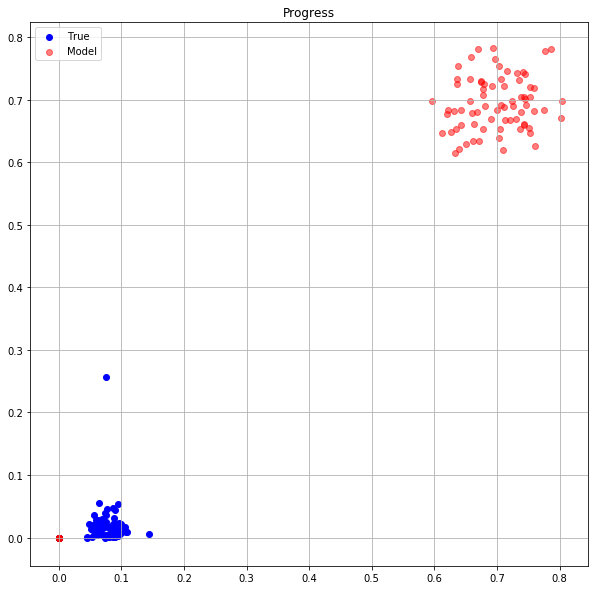

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.75it/s]


Train loss 0.4513934255	 Val loss 0.0774168149


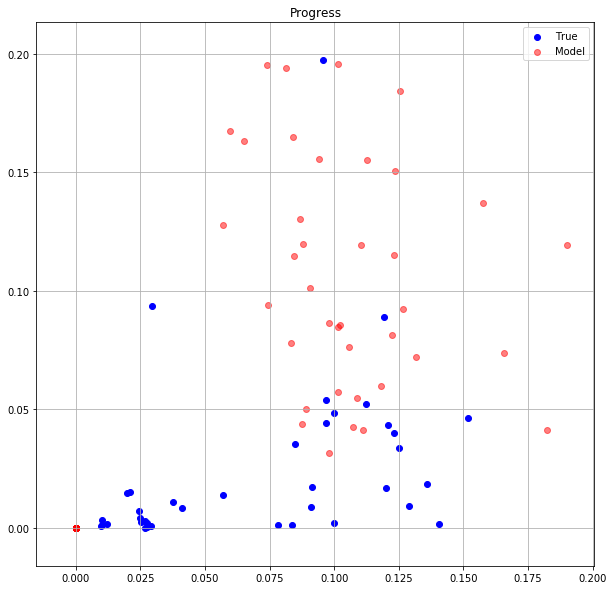

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.01it/s]


Train loss 0.0301928576	 Val loss 0.0206140373


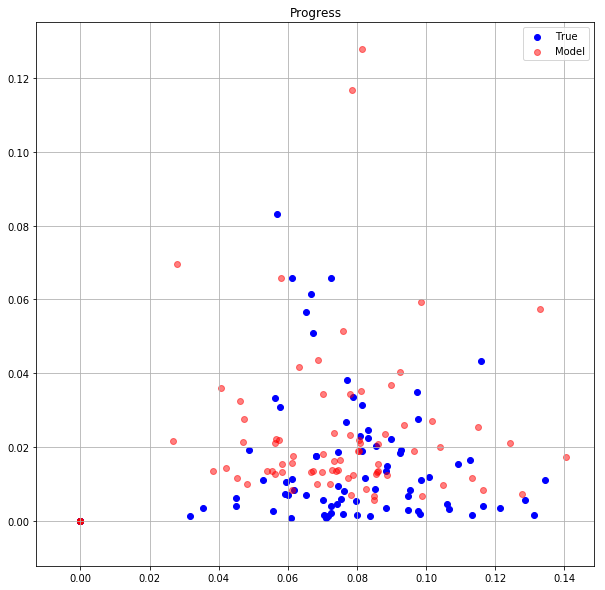

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.07it/s]


Train loss 0.0223894399	 Val loss 0.0202160031


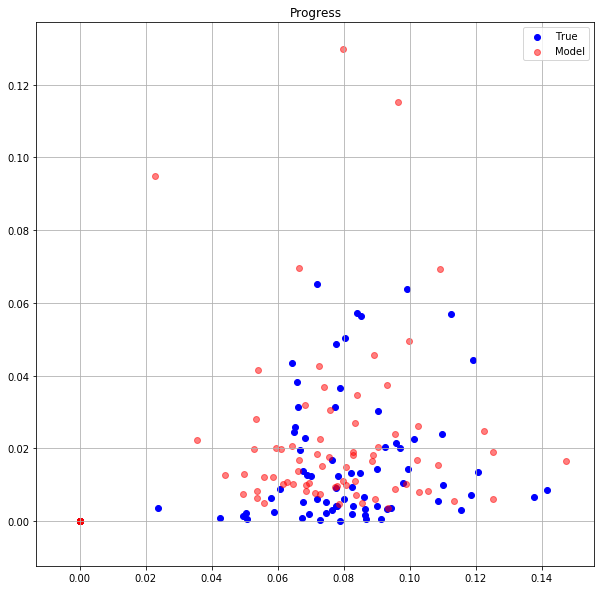

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.70it/s]


Train loss 0.0230389573	 Val loss 0.0293434076


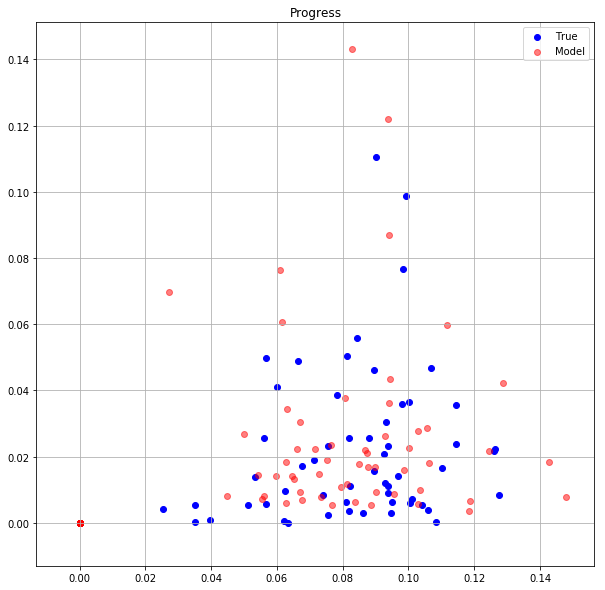

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.80it/s]


Train loss 0.0224596951	 Val loss 0.0255325269


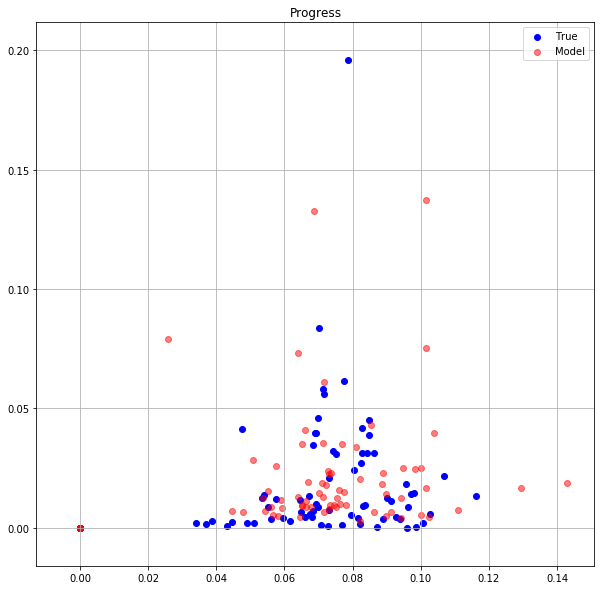

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.90it/s]


Train loss 0.0217301231	 Val loss 0.0197336134


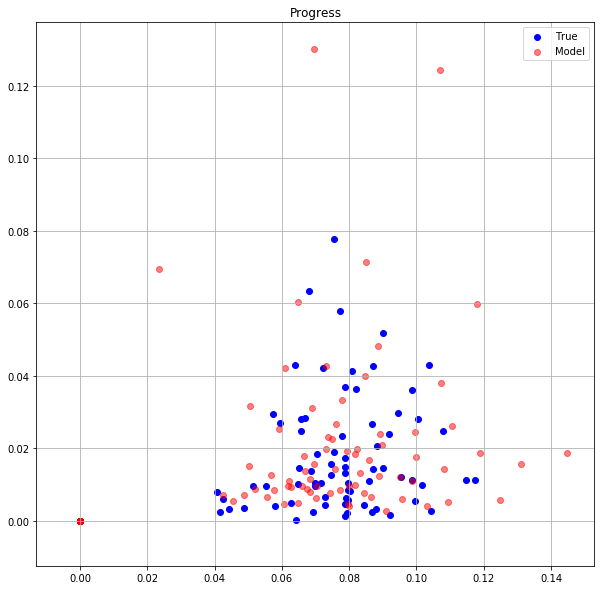

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:08<00:00,  2.97it/s]


Train loss 0.0221945122	 Val loss 0.0208926704


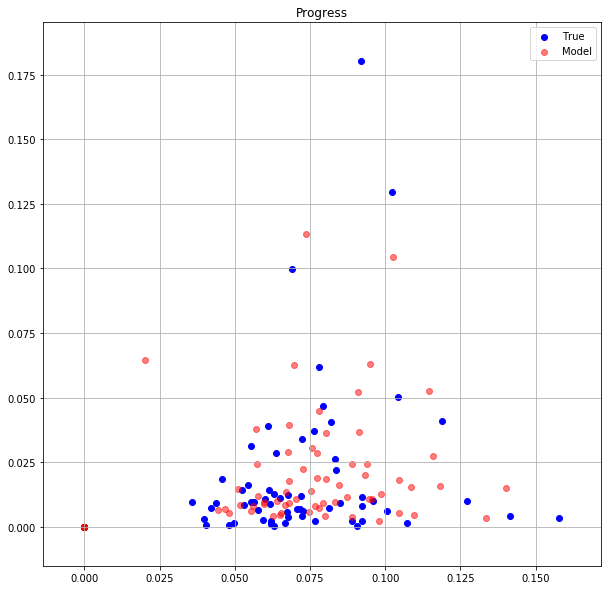

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.83it/s]


Train loss 0.0209201407	 Val loss 0.0197894331


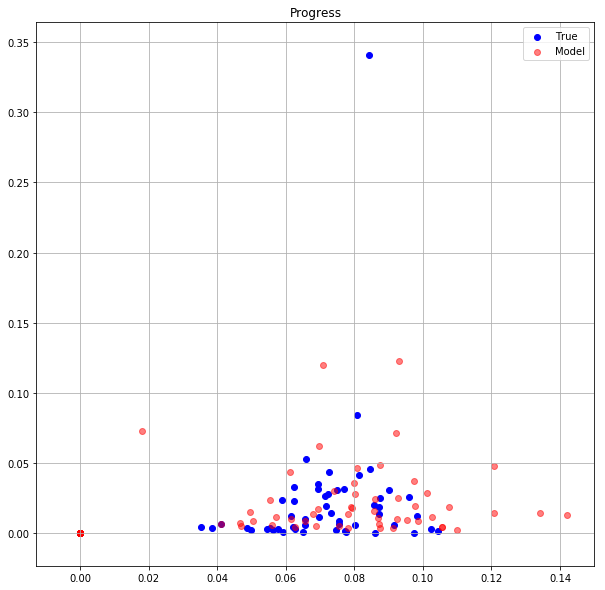

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.18it/s]


Train loss 0.0205886588	 Val loss 0.0211131014


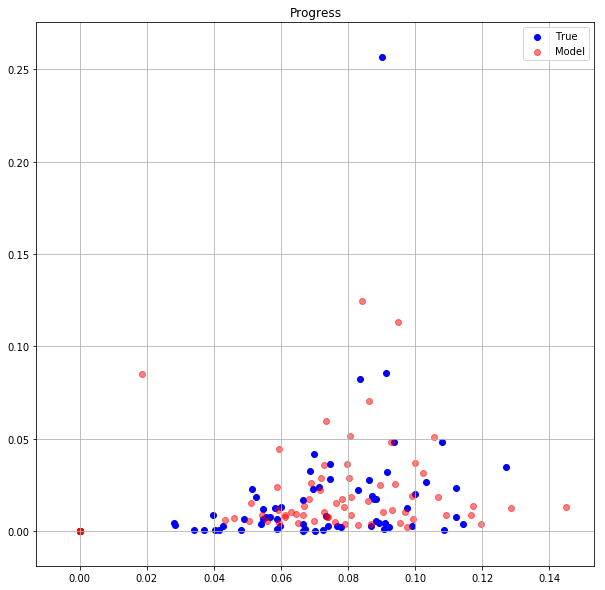

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.37it/s]


Train loss 0.0205697715	 Val loss 0.0193094593


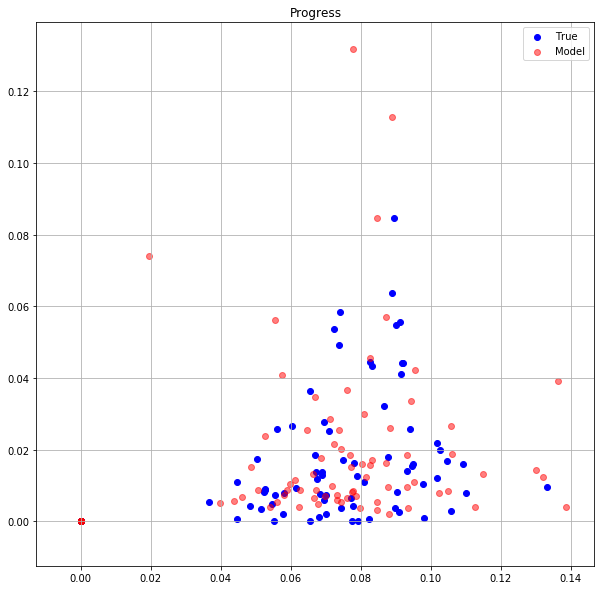

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.64it/s]


Train loss 0.0205158461	 Val loss 0.0193405971


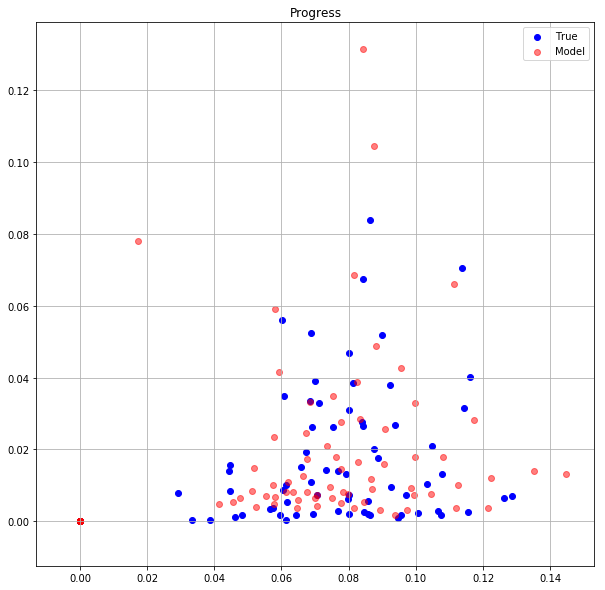

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.56it/s]


Train loss 0.0209027212	 Val loss 0.0210658982


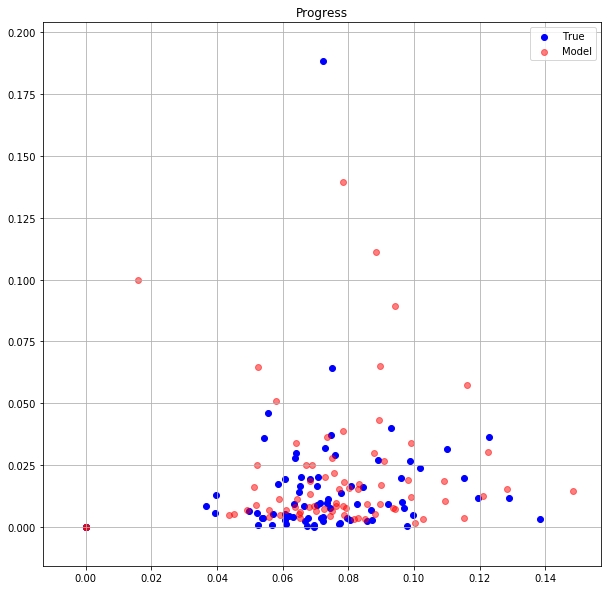

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.47it/s]


Train loss 0.0206540022	 Val loss 0.0197405666


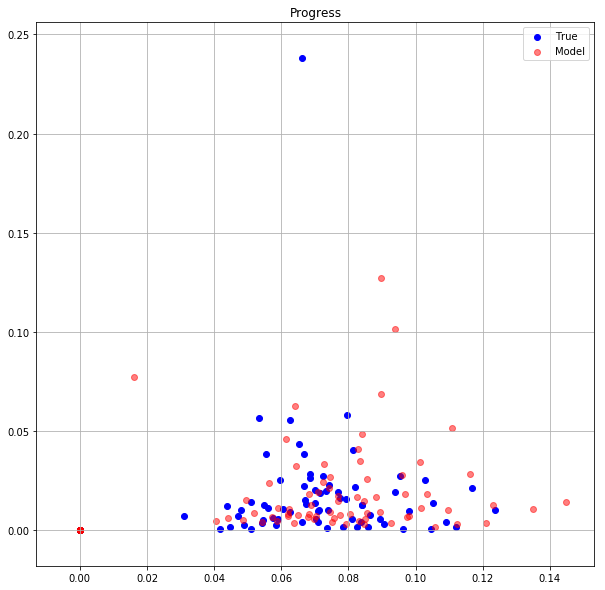

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.66it/s]


Train loss 0.0208960641	 Val loss 0.0201804563


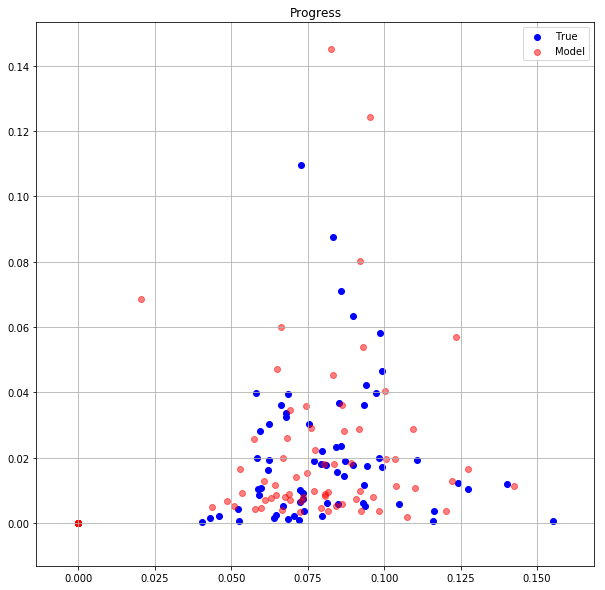

In [5]:
loss_train, loss_test = [], []
for epoch_idx in range(n_epochs):
    train_loss, test_loss = train_epoch_ae(model, dataloader_train, dataloader_test, optimizer, criterion)
    loss_train.append(train_loss)
    loss_test.append(test_loss)
    if epoch_idx < warmup_iters:
        scheduler1.step()
    else:
        if epoch_idx == warmup_iters:
            scheduler2 = ReduceLROnPlateau(optimizer, patience=20, min_lr=1e-6)
        scheduler2.step(test_loss)

In [8]:
#encoder = MLPEncoder(n_in=3, n_hidden=128, n_out=50, num_layers=4)
#decoder = MLPDecoder(n_in=50, n_hidden=128, n_out=n_max * set_channels, num_layers=4, set_channels=set_channels)
#model_approximator = AutoEncoderModel(encoder, decoder).to(device)

#checkpoint = torch.load("pretrained_models/mlp_baseline.pt", map_location=torch.device('cpu'))
#model_approximator.load_state_dict(checkpoint)

model_approximator = model

<All keys matched successfully>

In [6]:
model_classificator = CustomPersformer(n_in=3, embed_dim=64, fc_dim=128, num_heads=4, num_layers=5, n_out_enc=5, 
                                       dropout=0.0, reduction="attention").to(device)
checkpoint = torch.load("../pretrained_models/persformer_orbit5k_77_test_acc_only_one_dim.pt", map_location=torch.device('cpu'))
model_classificator.load_state_dict(checkpoint)

<All keys matched successfully>

In [9]:
pd_to_pd_ae_metrics(model_approximator, model_classificator, dataloader_train, dataloader_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:12<00:00,  1.99it/s]


(0.7825714285714286,
 0.7454285714285714,
 0.7773333333333333,
 0.7533333333333333,
 tensor(0.0052),
 tensor(0.0051))